--- 
Project for the course in Microeconometrics | Summer 2021, M.Sc. Economics, Bonn University | [Philipp Schreiber](https://github.com/pcschreiber1)

# Replication of Henderson, Storeygard, Deichmann (2017) :
## Has climate change driven urbanization in Africa? <a class="tocSkip">   
    
    
---

##### Downloading and viewing this notebook:

* The original paper, as well as the data and code provided by the authors can be accessed [here](https://doi.org/10.1016/j.jdeveco.2016.09.001).
* The shapefile has been downloaded from [Africa Open Data](https://africaopendata.org/dataset?tags=shapefiles).

## Content:
Extension: 
 - Spatial SUTVA/ <span style="color:orange">**NOTE**:</span> How large are the districts (important for whetehr SUTVA is reasonable or not)
 - Spatially explicit counterfactual framework
     - using exploration of SUTVA and spatial patters
         - spatial autocorrelation: Moran Plot and Moran's I
     - implementing (lagged dependent, lagged 

In [1]:
import geopandas as gpd
import shapely.geometry as geom
import libpysal as lp #For spatial weights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import statsmodels.formula.api as smf
#import geopandas as gpd
#import libpysal as lp
import seaborn as sns
import matplotlib.style as style


pd.options.display.float_format = "{:,.2f}".format

In [3]:
from auxiliary.data_import import *

---
# 1. Introduction 
---

In this paper Henderson et al. investigate the impact of increasing aridity on urbanization in Sub-Saharan Africa. In particular, the authors address the questions of i) *whether adverse changes in climate induce a push from rural to urban areas* and ii) *how this within-country migration affects incomes in cities/ the nature of the development effect of such an urbanization push on cities*.  They attribute previous studies' lack of significant findings to aggregation due to using national level data and, therefore, use variation at the district and city level. In addition, they construct a new data set of actual census data to overcome the reliance on interpolations, including the use of **night time lights (NTLs)**.

The authors outline a simple model of rural-urban migration to frame their analysis of the impact of rising aridity. The model suggests ...
<span style="color:red">***Shorter*** </span> <span style="color:blue">The authors model districs as small open economies which are differentiated by the presence of manufacturing facilities for potentially tradeable goods. In this context, a decline in moisture should only induce local migration in industrialized districts, since in exclusievly rural districts cities are only provide agriculture with services that not traded across districts, the local agricultural sector is not competing for labor.</span> This study employs **fixed effects (FE) regression** to account for all relevant influences. Finally, the authors support this by looking at evidence from India. The authors find strong evidence for the local migration, nut only in districts likely to produce tradable manufacturing goods. Similary, total income of local cities also only increases in districts liekly to produce tradable manufacturing goods. Understanding the patterns and effects of climate change on urbanization  is important both for providing assistance and to guide proactive policy. Africa projected to be especially affected by climate change ... Sucessful spatial and structural adaptation to climate change will critically depend on promoting cities' capacities.



<span style="color:blue">In this notebook, I replicate the results presented in the paper by Lindo et al. (2010). Furthermore, I discuss in detail the identification strategy used by the authors and evaluate the results using multiple robustness checks. My analysis offers general support for the findings of Lindo et al. (2010) and points out some factors which may enable a deeper understanding of the causal relationship explored in the paper. </span> In particular, I show that the SUTVA assumption is violated through spatial interdependence and **introduce a spatially explicity counterfactual model as an alternative**.

<span style="color:blue"> This notebook is structured as follows. In the next section, I present the performance standard model that lays down the theoretical framework for the paper (Section 2). In Section 3, I analyze the identification strategy that Lindo et al. (2010) use to unravel the causal effects of academic probation on student outcomes and Section 4 briefly discusses the empirical strategy the authors use for estimation. Section 5 and Section 6 constitute the core of this notebook. Section 5 shows my replication of the results in the paper and discussion thereof. In Section 6 I conduct various robustness checks and discuss some limitations of the paper. Section 7 offers some concluding remarks. </span>



---
# 2. Theoretical Background/ Literature
---

<span style="color:red">***What should be discussed here?*** </span>
<ul type="circle">  
 <li > <span style="color:blue"> What the literature says about this issues </span> </li>  
 <li> <span style="color:blue">  How urban migration and migration in the context of climate change has been studied </span> </li>  
</ul>

<span style="color:red">***Urban Models*** </span> <span style="color:blue"> 
     Mentioned in Henderson et al. 2017: (Duranton and Puga, 2004), (Desmet and Henderson, 2015)  
     Moreover: One of the earlier papers by henderson on urban model (Black and Henderson, 1999) </span> 

---
# 3. Data
---

In what follows I present the data. A study of 29 countries over the span ?30? years with subnational data require a sophisticated data set. For further detail, refer to the appendix of the original paper.

<h3><u>3.1 Urbanization</u></h3>
(urbanization over 10-15 years as a function of climate chnage over those years)

Most studies employ **population data** from infrequente national census reports and rely heavily on imputations and interpolations. This study includes countries with at least two available censuses with the relevant information for a complete or nearly complete set of sub-national units, where either district boundaries changed little or common units over time can be defined. The authors digitized data from hardycopy census publications. Of the 32 countries, Namibia, Congo-Brazzaville and Liberia were dropped due to issues of district definition or census frequency. The 29 remaining countries count between 2 to 5 censuses between 1960 and 2019. For estimation purposes Kenya is treated as two countries before and after the urban redefinition of the 1990s. While extensive, the sample omits several Sub-Saharan countries, most notably Nigeria, the most populous country on the continent. The countries were omitted either because the censuses did not include the needed information or printed volumes were unavailable. South Africa was excluded because of Post-Apartheid migration. Districs are large ... <span style="color:blue"> Need to explicitly say how "urban population" is measured. </span>

In contrast, high quality **climate data** is much more readily available. To reflect climatic agricultural potential the authors use precipitation over potential evapotranspiration (i.e. system supply over system demand) as a moisture index. The precipitation and temperature data is available from the University of Delaware gridded climate data set while PET is estimated using the Thornthwaite method. The district level climate indicator is then the average grid cell value that overlaps with the corresponding sub-national unit where cells that cross the boundary are weighted.

Sub-national **data on industrialization** is scarce in many census reports - before 1985 this is even true for national level indicators. Henderson et al. draw on the *Oxford Regional Economic Atlas, Africa* (Ady, 1965) which map all industries by type and city location, based on an in-depth analysis from a variety of sources from the late 1950s and early 1960s. From the total 26 industries the authors exclude 10 agricultural processing industries (e.g. brewing, milling) and use the count of different industries as the industrialization indicator. The full 26 industries have been used in robustness checks.

<h3><u>3.2 Income</u></h3>
(impact of annual climate fluctuations on annual city incomes and implied (possibly short-term) migration)

Due to the lack of consistently available **data on total city income**, **night time lights (NTLs)** are used as a proxy. The authors use annual average data from 1992 to 2008 using data from the U.S. Defense Meteorological Satellite Program (DMSP). As is typical in socioeconomic analysis, clouds and rainfally are excluded and only stable light sources are included. City income is then mapped as the sum of the light intensity of every pixel in the outer envelope. For further information on the use of NTLs see ... .  <span style="color:red">***Also*** </span> <span style="color:blue"> Established strong connection NTL and Henderson, Storeygard, and Weil (2012) was one of the first to formally test the relationship between changes in lights and economic growth</span> 

Since traditional **climate indexes** such as the moisture index are not available at such fine resolutions, rainfall is used instead. The data is used from the Rainfall Climatology Version 2, which combines weather station data with satellity information. Each city's hinterland annual average rainfall is then the average of grid-cell values within 30km of the ever-lit area. Since the moisture index split the sample almost evenly, "we calculate average near-city rainfall between 1983 (the first year in the data) and 1991, and split at the sample median".


---
# 4. Identification
--- 

Disaggregated data for such an extended period of time is extremely scarce, hence the analysis can only rely on a few key variables. 

(The biggest threat that the authors are concerned about are unobserved confounders.)

(Identification issues with proxies as "collider variables" (SUTVA paper Yale) -> problematic for NTLs?)
Hence, consider the following tree: (showing a fixed effect appropriate tree)

<h3><u>4.1 Fixed Effecs</u></h3>

Consider the following 

In the social science literature, two-way fixed effects (2FE) are extremely popular tools for accounting for both unit-specific (but time-invariant) and time-specific (but unit-invariant) *unobserved* confounders in a flexible manner. However, as Imai and Kim (2020) illustrate, their application requires careful consideration of the identification assumptions: besides the assumption of additivity and seperability of the unobserved variables, it also critically relies on the linearity of their effects. Moreover, the authors call into question 2FE's attractive connection to the explicitly causal framework fo difference-in-difference (DiD) and conclude that "the general multi-period DiD estimator is equivalent to the weighted two-way fixed effects regression estimator, but some oberservations have invalid (i.e.) negative weights" (p.9).

<img src="material/2FE_DAG_1.PNG" alt="Error: 2FE_DAG_1" style="width: 700;"/>

In [ ]:
A_GAD = gpd.read_file("C:/Projects/ose-data-science-course-project-pcschreiber1/data/GADM_v2_8_shapefile/gadm28.shp")
A_GAD.crs = "EPSG:4326"

In [ ]:
A_GAD.plot()

In [153]:
areg = gpd.read_file("C:/Projects/ose-data-science-course-project-pcschreiber1/data/Henderson_shapefile/afrregnew.gdb")
areg.crs = "EPSG:4326"

In [161]:
areg.head()

,lon,lat,afruid,iso3v10,FIRST_NAME_1,Shape_Length,Shape_Area,geometry
0,26.27,-21.54,72001,BWA,Central,19.02,12.79,"MULTIPOLYGON (((25.98728 -18.99912, 25.99368 -..."
1,22.60,-22.29,72002,BWA,Ghanzi,14.36,10.03,"MULTIPOLYGON (((23.88125 -20.99294, 23.89500 -..."
2,21.75,-24.86,72003,BWA,Kgalagadi,17.59,9.39,"MULTIPOLYGON (((20.03056 -23.30889, 20.04556 -..."
3,26.35,-24.15,72004,BWA,Kgatleng,4.00,0.69,"MULTIPOLYGON (((26.95521 -23.74904, 26.96656 -..."
4,24.69,-23.86,72005,BWA,Kweneng,8.51,3.27,"MULTIPOLYGON (((25.73333 -23.31361, 25.73583 -..."


In [156]:
gdb_join = gpd.sjoin(regiondata, areg, how="right", op="within")

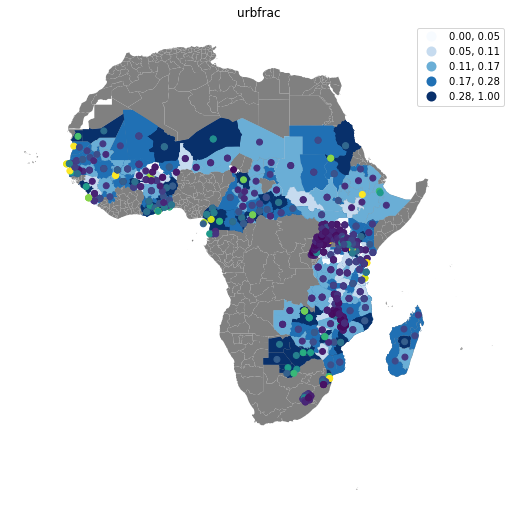

In [163]:
f, ax = plt.subplots(1, figsize=(9, 9))
#africa.boundary.plot(ax=ax, color="grey", linewidth=0.1)
africa.plot(ax=ax, color="grey")
gdb_join.plot(ax=ax, column="urbfrac", legend=True, scheme='Quantiles', cmap="Blues")
regiondata.plot(ax=ax, column="urbfrac")
ax.set_axis_off()
ax.set_title("urbfrac")
plt.axis('equal')
plt.show()

In [148]:
A_coast = gpd.read_file("C:/Projects/ose-data-science-course-project-pcschreiber1/data/Henderson_shapefile/gadm2afrcoastline.shp")
A_coast.crs = "EPSG:4326"

In [150]:
A_coast.head()

,LEFT_FID,RIGHT_FID,geometry
0,-1,0,"MULTILINESTRING ((44.33014 -25.26875, 44.33014..."
1,-1,0,"MULTILINESTRING ((5.63208 -1.40347, 5.63208 -1..."
2,-1,0,"MULTILINESTRING ((-24.68264 14.90097, -24.6826..."
3,-1,0,"MULTILINESTRING ((19.66764 -34.78625, 19.66764..."
4,-1,0,"LINESTRING (42.21347 13.62347, 42.21264 13.623..."


In [ ]:
africa=get_shapefile()

In [19]:
regiondata = pd.read_stata("data/regiondata.dta") #--> need to also do for other 
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")

#creating geopandas dataframe
regiondata["geometry"] = regiondata[["lon", "lat"]].apply(geom.Point, axis=1) #take each row
regiondata = gpd.GeoDataFrame(regiondata)
regiondata.crs = "EPSG:4326"

In [140]:
regiondata[regiondata["iso3v10"]=="SDN"]["province"]

451    Central Region ( Gezeira + Blue Nile + White N...
452    Central Region ( Gezeira + Blue Nile + White N...
453                                               Darfur
454                                               Darfur
455         Eastern region (Red Sea+ Kassala+Al Gadarif)
456         Eastern region (Red Sea+ Kassala+Al Gadarif)
457                                             Khartoum
458                                             Khartoum
459                                             Kordofan
460                                             Kordofan
461                    Northern (Nile+Northern province)
462                    Northern (Nile+Northern province)
463                                        Bar El Ghazal
464                                        Bar El Ghazal
465                              Equatoria (East + West)
466                              Equatoria (East + West)
467                                  Upper Nile +Jongley
468                            

In [146]:
africa[["name_local", "region", "name_en", "region_sub"]]

,name_local,region,name_en,region_sub
28,None,None,Southern Nations,None
29,None,Equatoria,Eastern Equatoria,None
30,None,None,Somali Region,None
31,None,None,Nugal,None
32,None,None,Mudug,None
...,...,...,...,...
4500,None,None,Selebi-Phikwe,Central
4501,None,None,Sowa,Central
4545,None,None,None,Fianarantsoa
4546,None,None,None,Fianarantsoa


In [142]:
africa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 918 entries, 28 to 4547
Data columns (total 85 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   featurecla  918 non-null    object  
 1   scalerank   918 non-null    int64   
 2   adm1_code   918 non-null    object  
 3   diss_me     918 non-null    int64   
 4   iso_3166_2  918 non-null    object  
 5   wikipedia   75 non-null     object  
 6   iso_a2      918 non-null    object  
 7   adm0_sr     918 non-null    int64   
 8   name        918 non-null    object  
 9   name_alt    308 non-null    object  
 10  name_local  52 non-null     object  
 11  type        865 non-null    object  
 12  type_en     865 non-null    object  
 13  code_local  53 non-null     object  
 14  code_hasc   918 non-null    object  
 15  note        78 non-null     object  
 16  hasc_maybe  27 non-null     object  
 17  region      274 non-null    object  
 18  region_cod  253 non-null    object  
 19

In [139]:
africa[africa["iso_a2"]=="SD"]["name"]

369      Central Darfur
370     Southern Darfur
1163            Gedarif
1166          Blue Nile
1167             Sennar
1483           Northern
1487         River Nile
1488            Red Sea
1508       North Darfur
1509     Western Darfur
1656            Kassala
1666         White Nile
1667     South Kordufan
1673     Eastern Darfur
3406             Gezira
3407           Khartoum
3408     North Kordufan
Name: name, dtype: object

In [14]:
africa = get_shapefile()

In [17]:
africa.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
regiondata["geometry"]

0      POINT (26.27291 -21.53998)
1      POINT (22.59946 -22.29412)
2      POINT (26.35415 -24.15221)
3      POINT (24.68634 -23.86279)
4      POINT (27.56638 -21.01738)
                  ...            
736      POINT (36.76430 0.32742)
737     POINT (36.91174 -2.12603)
738     POINT (35.57377 -1.25378)
739     POINT (36.07835 -0.47175)
740     POINT (35.30454 -0.50249)
Name: geometry, Length: 717, dtype: geometry

In [65]:
#A_region = gpd.sjoin(africa, regiondata, how="inner", op="within")
A_region = gpd.sjoin(regiondata, africa, how="right", op="within")

In [66]:
regiondata[["ADsm0_2moistu"]].isna().sum()

ADsm0_2moistu    0
dtype: int64

In [80]:
A_region[["ADsm0_2moistu"]].isna().sum()

ADsm0_2moistu    631
dtype: int64

In [99]:
colnames(A_region)

28      POLYGON ((35.32077 5.34872, 35.30237 5.35737, ...
29      POLYGON ((35.26930 5.49178, 35.27364 5.47987, ...
30      POLYGON ((47.97917 7.99657, 47.93059 7.94970, ...
31      POLYGON ((47.53239 7.56586, 47.54168 7.57484, ...
32      POLYGON ((46.46696 6.53829, 46.48805 6.55864, ...
                              ...                        
4500    POLYGON ((27.86603 -21.92074, 27.87024 -21.924...
4501    POLYGON ((26.12634 -20.54459, 26.14366 -20.546...
4545    POLYGON ((46.98809 -22.27506, 47.03820 -22.362...
4546    POLYGON ((45.76040 -21.77396, 45.67271 -21.761...
4547    POLYGON ((47.13063 -18.73667, 47.17685 -18.747...
Name: geometry, Length: 1343, dtype: geometry

In [106]:
regiondata["iso3v10"].unique()

array(['BWA', 'CMR', 'CAF', 'TCD', 'BEN', 'GNQ', 'ETH', 'GMB', 'GHA',
       'GIN', 'KEN', 'LSO', 'MDG', 'MWI', 'MLI', 'MRT', 'MOZ', 'NER',
       'RWA', 'SEN', 'SLE', 'ZWE', 'SDN', 'SWZ', 'TGO', 'UGA', 'TZA',
       'BFA', 'ZMB', 'KEN2'], dtype=object)

In [108]:
regiondata[regiondata["iso3v10"]=="SDN"][["ADsm0_2moistu", "geometry"]].describe()

,ADsm0_2moistu
count,18.00
mean,0.00
std,0.01
min,-0.03
25%,-0.01
50%,0.00
75%,0.01
max,0.02


In [109]:
A_region[A_region["iso_a2"]=="SD"][["ADsm0_2moistu", "geometry"]].describe()

,ADsm0_2moistu
count,12.00
mean,0.00
std,0.01
min,-0.03
25%,-0.01
50%,0.00
75%,0.01
max,0.02


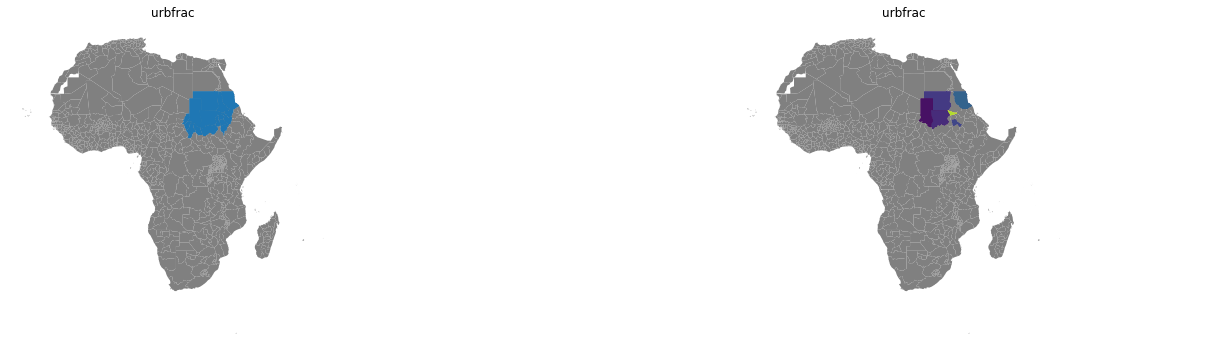

In [122]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
#africa.boundary.plot(ax=ax, color="grey", linewidth=0.1)
ax = ax.flatten()
axs = ax[0]
africa.plot(ax=axs, color="grey")
A_region[A_region["iso_a2"]=="SD"].plot(ax=axs, column="iso_a2")
axs.set_axis_off()
axs.set_title("urbfrac")
plt.axis('equal')

axs = ax[1]
africa.plot(ax=axs, color="grey")
A_region[A_region["iso_a2"]=="SD"].plot(ax=axs, column="urbfrac")
axs.set_axis_off()
axs.set_title("urbfrac")
plt.axis('equal')

plt.show()

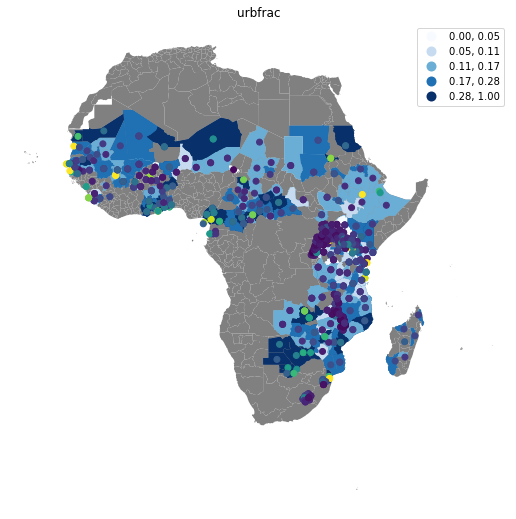

In [147]:
f, ax = plt.subplots(1, figsize=(9, 9))
#africa.boundary.plot(ax=ax, color="grey", linewidth=0.1)
africa.plot(ax=ax, color="grey")
A_region.plot(ax=ax, column="urbfrac", legend=True, scheme='Quantiles', cmap="Blues")
regiondata.plot(ax=ax, column="urbfrac")
ax.set_axis_off()
ax.set_title("urbfrac")
plt.axis('equal')
plt.show()

<h3><u>4.2 Spatial Effects (Extension)</u></h3>

<span style="color:blue"> Explain what spatial correlation etc. is </span>

A common strategy for maintaining SUTVA is spatially aggregating data (see Imbens and Rubin 2015; Morgan and Winship 2014). While popular, it is evident that this non-strategy directly undermines the added-value of disaggregated data. Translating this to the present study, the issue is whether districts can really be believed to be independent open economies. While the authors admit that there is considerable cross-country variability, they argue that on average districts are "large. But as can be seen from the histogram below, the distribution is indeed very skewed - with few enormous districts strongly inflating the average. Indeed, more than half of the districts are smaller than $12.000 \:km^2$, which roughly corresponds to the size of Northern Ireland or Montenegro. This, however, significantly undermines the plausibility of "no-spillover effects". 

As Kolak and Anselin (2019) point out, this highlights a more fundamental problem - in many disaggregated, spatially-motivated analyses, *SUTVA is incomaptible with the dynamics of interest*, namely the interplay of disaggregated communities. For that reason, Kolak and Anselin seek to set the foundation of a **spatially explicit counterfactual framework**, arguing that "explicit spatial perspective of the counterfactual framework considers spatial effects in the structure of the research design and assesses their influence on assignment and on the final treatment effect evaluation" (p.130). And while they provide few practical guidelines, the authors explain that this "also requires controlling for violations of the assumption of independence between observations and outcomes, in combination with spatial effects, that is, SD (spillover effects) and SH (different responses in different contexts)" (p.130). Here Castner et al.'s (2014) insight that, in disaggregated data, there exists a "fundamental trade-off between SUTVA and ignorability" (p.9) reveals at least one possible entry point for making the counterfactual spatial: breaking down the distinction between ignorability. Rather than clinging to the SUTVA assumption, the interaction effects need to be carefully examined as part of the identification procedure. Consider the following DAG:

<img src="material/Spatial_DAG_colour_2.PNG" alt="Error: Should Display spatial DAG colour 1" style="width: 700;"/>

In order to understand whether identification is still possible, we first need to better understand the pattern of spatial interdependence present here. Let us now proceed to explore the patterns of spatial interdependence.

In [7]:
#------------------------------------------------------
#---  Analysing district sizes   ----------------------
#------------------------------------------------------

#trying to see the smallest district
regiondata = importing_regiondata()
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")

regiondata[["iso3v10", "province", "areasqkm"]].describe()

,areasqkm
count,717.00
mean,"40,877.00"
std,"78,686.27"
min,72.64
25%,"3,605.99"
50%,"11,666.68"
75%,"48,939.07"
max,"623,518.25"


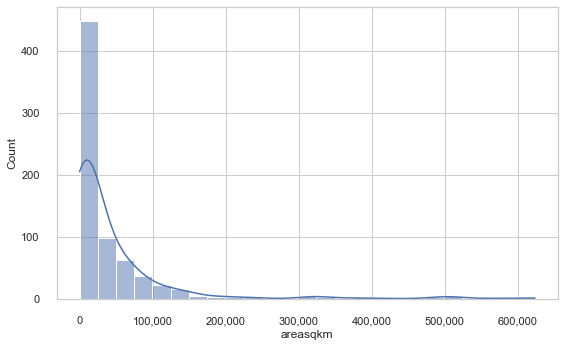

In [51]:
n_bins = 25

fig, ax = plt.subplots(figsize=(8, 5))
sns.set_theme(style='whitegrid')
g = sns.histplot(ax=ax, x=regiondata['areasqkm'], bins=n_bins, kde=True)
g.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

<h4 style="color:SlateGray;">Exploring Spatial Patterns</h4>

The climate "naturally" generates spatial patterns in the sense that "if location A is sufficiently close to location B, then A will very likely experience a similar climate". We refer to this as **positive spatial autocorrelation**. <span style="color:red"> However, if we still block the back-door paths, we don't have a problem </span>. 

A *chloropeth graph* helps us explore the nature of the spatial patterns.

In [99]:
#------------------------------------------------------
#---  Analysing pattern of interdependence ------------
#------------------------------------------------------

#Get spatial data
regiondata = get_spatialdata()
africa = get_shapefile()

C:\projects\ose-data-science-course-project-pcschreiber1\auxiliary\data_import.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regiondata["geometry"] = regiondata[["lon", "lat"]].apply(geom.Point, axis=1) #take each row


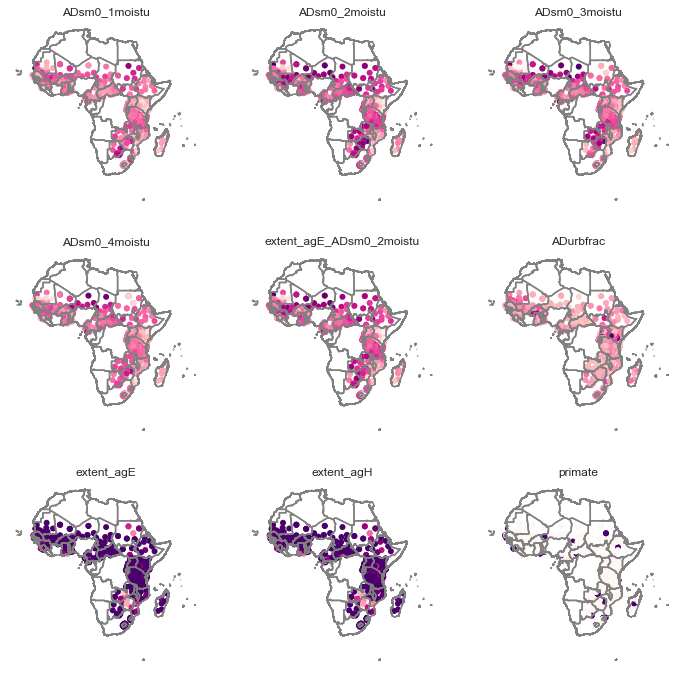

In [104]:
regiondata = pd.read_stata("data/regiondata.dta") #--> need to also do for other 
regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")

#creating geopandas dataframe
regiondata["geometry"] = regiondata[["lon", "lat"]].apply(geom.Point, axis=1) #take each row
regiondata = gpd.GeoDataFrame(regiondata)
regiondata.csr = "EPSG:4326"
#a = regiondata.columns
#a = a[26:35]
a = ["ADsm0_1moistu", "ADsm0_2moistu", "ADsm0_3moistu", "ADsm0_4moistu", "extent_agE_ADsm0_2moistu", "ADurbfrac", "extent_agE", "extent_agH", "primate"]

f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(a):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    regiondata.plot(column=col, ax=ax, linewidth=0, cmap='RdPu')#, scheme='Quantiles', linewidth=0, cmap='RdPu')
    # Remove axis clutter
    africa.boundary.plot(ax=ax, color='grey')
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

The Moran's plot is way to analyse the spatial dependence more formally. For the implementation we rely on <span style="color:red"> spatial weights </span> to generate the *spatial lag* of the variable of interest (<span style="color:red"> 8 nearest neighbours is being used</span>). The spatial lag defines "spatial proximity" and then captures the bahaviour of a variable in the immediate surroundings of each location. Non-neighbours receive a weight of zero and, hence, the (standardized) weight matrix becomes a "*local average*" of the variabe. Moran's I then fits a linear trend to approximate the relationship (for further information see ).

As can be seen from the plot below, Moran's I indicates the presence of a global positive spatial autocorrelation: similar values tend to be located close to each other. Hence, districts with a decrease in moisture tend to be located nearby districts which also experience a decrease in moisture. The ESDA package then uses a simulation study to confirm the results.

[but is it really this "simple" spatial autocorrelation that we should be worried about?]




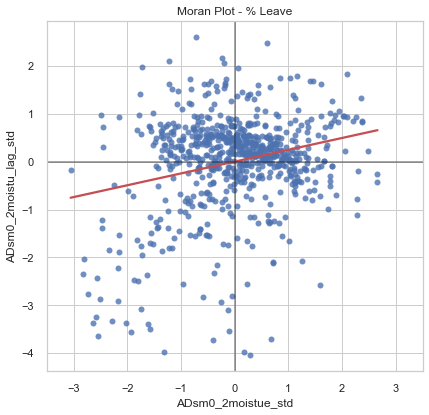

Moran's I: 0.247 with a p-value of 0.000000.


In [96]:
#------------------------
#--- Moran's I ----------
#------------------------

w = lp.weights.KNN.from_dataframe(regiondata, k=8) #k nearest neighbour weights
w.tranform = "R" #row-standardization
regiondata['ADsm0_2moistu_lag'] = lp.weights.spatial_lag.lag_spatial(w, regiondata['ADsm0_2moistu']) #create a lag of the variable

#standardize the original variable and the lag
regiondata['ADsm0_2moistue_std'] = ( regiondata['ADsm0_2moistu'] - regiondata['ADsm0_2moistu'].mean() )\
                    / regiondata['ADsm0_2moistu'].std()
regiondata['ADsm0_2moistu_lag_std'] = ( regiondata['ADsm0_2moistu_lag'] - regiondata['ADsm0_2moistu_lag'].mean() )\
                    / regiondata['ADsm0_2moistu_lag'].std()


sns.set_theme(style='whitegrid')

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='ADsm0_2moistue_std', y='ADsm0_2moistu_lag_std', ci=None, data=regiondata, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
ax.xlabel=("ADsm0_2moistue")
ax.ylabel=("ADsm0_2moistue_lag")
plt.xlim(-3.5, 3.5)
plt.show()
#get the Moran's I and its statistical significance
stat = smf.ols(formula="ADsm0_2moistu_lag_std ~ ADsm0_2moistue_std", data=regiondata).fit()
Moran = stat.params[1]
p_value = stat.pvalues[1] 
print(f"Moran's I: {Moran:.3f} with a p-value of {p_value:f}.")

In [88]:
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.explore import esda

Moran's I: 0.112 and a pseudo p-value of 0.001.


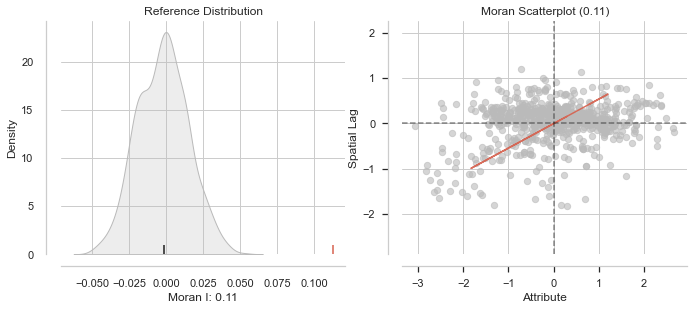

In [94]:
moran = esda.moran.Moran(regiondata['ADsm0_2moistu'], w)
moran.I
moran.p_sim

plot_moran(moran);
print(f"Moran's I: {moran.I:.3f} and a pseudo p-value of {moran.p_sim:.3f}.")

<h4 style="color:SlateGray;">Spatially explicity counterfactual model</h4>

<span style="color:red"> Dealing with spatial interdependence </span>

<span style="color:red"> District/country fixed effects **?** </span> do not address spatial interdependence. In fact, they address the opposite issue: that, while countries have a common trend, there are unobserved *differences*. But what is needed is to account for the systematic *similarity* of districtics. Hence, aggregation is the author's only safeguard against a SUTVA violation. So we proceed to examine this issue more closely.

### Region data (table 1a and 2)

In [1]:
regiondata = importing_regiondata()
#regiondata = regiondata.query("abspctileADsm0_2moistu > 6 & abspctileADurbfrac > 6")

a = table_1_a(regiondata)
regiondata[["ADurbfrac", "ADsm0_1moistu", "ADsm0_2moistu", "extent_agE_ADsm0_2moistu", "countryyear", "afruid"]].head()

NameError: name 'importing_regiondata' is not defined

In [5]:
table_2(regiondata).params[["ADsm0_2moistu", "firsturbfrac",  "lndiscst"]]

ADsm0_2moistu   -0.08
firsturbfrac    -0.05
lndiscst         0.00
dtype: float64

In [6]:
df_subgroup = regiondata[["isoyr", "iso3v10", "province"]]
df_subgroup.loc[(slice(20,30))]

,isoyr,iso3v10,province
20,CMR1987,CMR,Sud-Ouest
21,CMR2005,CMR,Sud-Ouest
22,CAF1988,CAF,Bamingui-Bangoran
23,CAF2003,CAF,Bamingui-Bangoran
24,CAF1988,CAF,Basse-Kotto
25,CAF2003,CAF,Basse-Kotto
26,CAF1988,CAF,Haut-Mbomou
27,CAF2003,CAF,Haut-Mbomou
28,CAF1988,CAF,Haute-Kotto
29,CAF2003,CAF,Haute-Kotto


## Exploring countrydata and reproducing Figure 4 (Variability in climate change in Africa)

In [7]:
countrydata_allyears = pd.read_stata("data/countrydata_allyears.dta")

countrydata_allyears["sm0_2normarid"] = countrydata_allyears["sm0_2moistu"]/ countrydata_allyears["mean_moistu1950_69"]

In [8]:
countrydata_allyears.head()

,year,iso3v10,moistu,sm0_2moistu,sm0_2preu,sm0_2tmpu,yearssince_prev_census,isonv10,areasqkm,urbpop,...,sum_agE,_merge,ADurbfrac,ADprimatefrac,ADprimwidefrac,ADsm0_2moistu,ADsm0_2preu,ADsm0_2tmpu,mean_moistu1950_69,sm0_2normarid
0,1950,BWA,0.42,NaN,NaN,NaN,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,NaN
1,1951,BWA,0.39,NaN,NaN,NaN,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,NaN
2,1952,BWA,0.36,0.39,427.86,21.61,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,0.99
3,1953,BWA,0.47,0.41,434.43,21.21,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,1.03
4,1954,BWA,0.46,0.43,454.84,21.13,NaN,72.00,"578,084.72",NaN,...,NaN,master only (1),NaN,NaN,NaN,NaN,NaN,NaN,0.39,1.09


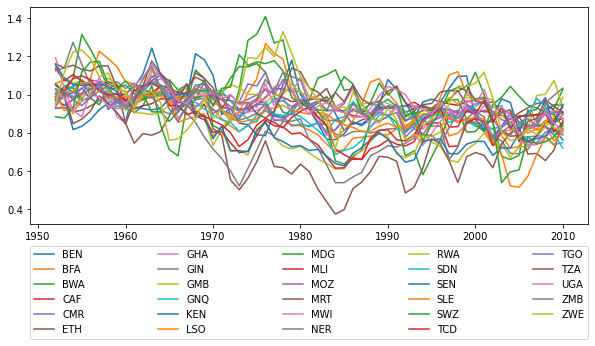

In [9]:
countrydata_allyears = pd.read_stata("data/countrydata_allyears.dta")
figure_4(countrydata_allyears)

### Exploring City data and reproducing table 6 (Change in city output and rainfall: heterogeneity by industrialization)

In [10]:
citydata = pd.read_stata("data/citydata.dta")
#citydata[["iso3v10", "year", "dlnrain30", "dlnl1", "agidison"]]
citydata.head()

,iso3v10,agidison,extent_agE,extent_agH,year,rain30,cityavgrain1983_1991,rain30trim257,cityavgrain1983_1991trim257,todn,...,extent_agHcflcnt3,extent_agHLcflcnt3,extent_agHcflcnt3_50,extent_agHLcflcnt3_50,extent_agH_dlnrainnatconflict,extent_agH_dlnrainLnatconflict,extent_agH_dlnraincflcnt3,extent_agH_dlnrainLcflcnt3,extent_agH_dlnraincflcnt3_50,extent_agH_dlnrainLcflcnt3_50
0,MRT,6082478,10.00,14.00,0.00,0.11,0.21,0.10,0.12,851.00,...,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MRT,6082478,10.00,14.00,1.00,0.17,0.21,0.14,0.12,"1,170.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,MRT,6082478,10.00,14.00,2.00,0.27,0.21,0.11,0.12,"1,073.50",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,MRT,6082478,10.00,14.00,3.00,0.21,0.21,0.11,0.12,"1,359.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,MRT,6082478,10.00,14.00,4.00,0.23,0.21,0.14,0.12,"1,457.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Exploring Spatial regression in Python

In [11]:
import geopandas as gpd
import shapely.geometry as geom
import libpysal as lp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OSError: could not find or load spatialindex_c-64.dll

In [ ]:
citydata = pd.read_stata("data/citydata.dta")

In [ ]:
#creating geopandas dataframe

citydata["geometry"] = citydata[["lon", "lat"]].apply(geom.Point, axis=1) #take each row
citydata = gpd.GeoDataFrame(citydata)
citydata.csr = "epsg:102113"

In [ ]:
#Source https://africaopendata.org/dataset?tags=shapefiles
africa = gpd.read_file("C:/Projects/ose-data-science-course-project-pcschreiber1/data/afr_g2014_2013_0.shp")


In [ ]:
africa.crs = "EPSG:4326"

In [ ]:
africa.boundary.plot()

In [ ]:
citydata.crs = "EPSG:4326"
citydata.plot()

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
africa.boundary.plot(ax=ax, color='lightgrey')
citydata.to_crs(epsg=4326).plot(ax=ax)
plt.show()

#### Choropleth mapping

In [ ]:
citydata.info()

In [ ]:
print("mean Rain 30: ", citydata["rain30"].mean())
print("median Rain 30: ", citydata["rain30"].median())
h = plt.hist(citydata["rain30"], bins=10)

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
africa.boundary.plot(ax=ax, color='grey')
citydata.plot(ax=ax, column='rain30', legend=True,  #, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues')
ax.set_axis_off()
ax.set_title('rain30')
plt.axis('equal')
plt.show()

#### Spatial patterns

In [ ]:
regiondata = pd.read_stata("data/regiondata.dta")

In [ ]:
#creating geopandas dataframe
regiondata["geometry"] = regiondata[["lon", "lat"]].apply(geom.Point, axis=1) #take each row
regiondata = gpd.GeoDataFrame(regiondata)
regiondata.csr = "EPSG:4326"

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
africa.boundary.plot(ax=ax, color='lightgrey')
regiondata.plot(ax=ax)
plt.title("Regiondata plotted (no variable)")
plt.show()

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))
africa.boundary.plot(ax=ax, color='grey')
regiondata.plot(ax=ax, column="ADsm0_2moistu", legend=True,  #, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues')
ax.set_axis_off()
ax.set_title('rain30')
plt.axis('equal')
plt.title("Regiondata plotted (moisture)")
plt.show()

 - chloropeth for analysing several dimensions

In [ ]:
a = regiondata.columns
a = a[26:35]

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(a):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    regiondata.plot(column=col, ax=ax, linewidth=0, cmap='RdPu')#, scheme='Quantiles', linewidth=0, cmap='RdPu')
    # Remove axis clutter
    africa.boundary.plot(ax=ax, color='grey')
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

### Spatial weights

In [ ]:
w = lp.weights.KNN.from_dataframe(regiondata, k=8) #k nearest neighbour weights
w.tranform = "R" #row-standardization
regiondata['ADsm0_2moistu_lag'] = lp.weights.spatial_lag.lag_spatial(w, regiondata['ADsm0_2moistu'])

In [ ]:
regiondata["iso3v10"]

In [ ]:
regiondata[["ADsm0_2moistu_lag",].head()

In [ ]:
regiondata.index

 - Global Autocorrelation: Moran Plot and Moran's I (finding whether **there are** clusters)
     - Need either pysal "edas" or maybe can do Moran's I p-value with statsmodel?


<div class="alert alert-block alert-info"><b>Note:</b> Here the weights are constructed using k=8 nearest neighbors</div>

In [ ]:
#standardize the original variable and the lag
regiondata['ADsm0_2moistue_std'] = ( regiondata['ADsm0_2moistu'] - regiondata['ADsm0_2moistu'].mean() )\
                    / regiondata['ADsm0_2moistu'].std()
regiondata['ADsm0_2moistu_lag_std'] = ( regiondata['ADsm0_2moistu_lag'] - regiondata['ADsm0_2moistu_lag'].mean() )\
                    / regiondata['ADsm0_2moistu_lag'].std()

In [ ]:
# moran = lp.esda.moran.Moran(regiondaata['ADsm0_2moistu'], w) #not available in libpysal

f, ax = plt.subplots(1, figsize=(6, 6))
plt.scatter(x='ADsm0_2moistue_std', y='ADsm0_2moistu_lag_std', data=regiondata)
m, b = np.polyfit(x=regiondata['ADsm0_2moistue_std'], y=regiondata['ADsm0_2moistu_lag_std'], deg = 1)
plt.plot(regiondata["ADsm0_2moistue_std"], m*regiondata["ADsm0_2moistue_std"]+b, color="red" )
#ax.axvline(0, c='k', alpha=0.5)
#ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - ADsm0_2moistue ')
plt.xlabel=("ADsm0_2moistue")
plt.ylabel=("ADsm0_2moistue_lag")
plt.show()
print(f"Moran's I: {m:f}")

 - Moran's I for several variables

In [ ]:
a = regiondata.columns
a = a[26:35]
# Weigths
w = lp.weights.KNN.from_dataframe(regiondata, k=8) #k nearest neighbour weights
w.tranform = "R" #row-standardization

f, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
for counter, i in enumerate(a):
    regiondata[f"{i}_lag"] = lp.weights.spatial_lag.lag_spatial(w, regiondata[i])
       
    #standardize the original variable and the lag
    regiondata[f"{i}_std"] = ( regiondata[i] - regiondata[i].mean() )\
                    / regiondata[i].std()
    regiondata[f"{i}_lag_std"] = ( regiondata[f"{i}_lag"] - regiondata[f"{i}_lag"].mean() )\
                    / regiondata[f"{i}_lag"].std()

    ax = axs[counter]
    ax.scatter(x=f"{i}_std", y=f"{i}_lag_std", data=regiondata)
    m, b = np.polyfit(x=regiondata[f"{i}_std"], y=regiondata[f"{i}_lag_std"], deg = 1)
    ax.plot(regiondata[f"{i}_std"], m*regiondata[f"{i}_std"]+b, color="red")

    ax.set_title(f'Moran Plot - {i} ')
    ax.xlabel=(f"{i}")
    ax.ylabel=(f"{i}")
    

plt.tight_layout()
plt.show()



In [ ]:
a

In [ ]:
## Elegant way using the Moran Function!!
#   # Set seed for reproducibility | why need seed for moran's I?
#   numpy.random.seed(123456)
#   # Calculate Moran's I for each variable
#   mi_results = [Moran(regiondata[variable], w) for variable in a]
#   # Display on table
#   table = pandas.DataFrame([(variable, res.I, res.p_sim) \
#                             for variable,res \
#                             in zip(cluster_variables, mi_results)
#                            ], columns=['Variable', "Moran's I", 'P-value']
#                           )\
#                 .set_index('Variable')
#   table

 - considering pairwise variation (because the Moran's plot only considers how one variable relates on space)

In [ ]:
_ = sns.pairplot(regiondata[a], kind='reg', diag_kind='kde')

 - local measures of spatial autocorrelation (finding **where** clusters are)
     - Local Moran's I (continue here https://geographicdata.science/book/notebooks/07_local_autocorrelation.html )

### Point-Pattern analysis
- scatter-plot: use seaborn for scatter plot with histogram on the sides

<div class="alert alert-block alert-danger"><b>Note:</b> This chapter is about analysing the LOCATION of points, not the pattern of the values</div>

In [ ]:
import seaborn as sns

In [ ]:
sns.jointplot(x='lon', y='lat', data=regiondata, s=0.5);

 - Hex-binning
 <div class="alert alert-block alert-danger"><b>Warning</b> Potentially meaningless since it will record for the same county multiple times - so rather than density of observations we get "density of census"</div>

In [ ]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    regiondata['lon'], 
    regiondata['lat'],
    gridsize=50, 
    linewidths=0,
    alpha=0.5, 
    cmap='viridis_r'
)
africa.boundary.plot(ax=ax, color='grey')
# Add basemap

#contextily.add_basemap(
#    ax, 
#    source=contextily.providers.CartoDB.Positron
#)

# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

plt.show()

In [ ]:
# Set up figure and axis
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 24))
axs = axs.flatten() #so can be called using single index

# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
data = [regiondata, citydata]
title = ["regiondata", "citydata"]

for counter, i in enumerate(data):
    ax = axs[counter]
    hb = ax.hexbin(
        i['lon'], 
        i['lat'],
        gridsize=50, 
        linewidths=0,
        alpha=0.5, 
        cmap='viridis_r'
    )
    africa.boundary.plot(ax=ax, color='grey')
    ax.set_aspect('equal')
    ax.set_title(title[counter])

## Add colorbar
#plt.colorbar(hb)

plt.show()

 - Kernel Density Estimation (KDE)
     - Requires Seaborn

In [ ]:
#     # Set up figure and axis
#     f, ax = plt.subplots(1, figsize=(9, 9))
#     # Generate and add KDE with a shading of 50 gradients 
#     # coloured contours, 75% of transparency,
#     # and the reverse viridis colormap
#     seaborn.kdeplot(
#         db['x'], 
#         db['y'],
#         n_levels=50, 
#         shade=True,
#         alpha=0.55, 
#         cmap='viridis_r'
#     )
#     # Add basemap
#     contextily.add_basemap(
#         ax, 
#         source=contextily.providers.CartoDB.Positron
#     )
#     # Remove axes
#     ax.set_axis_off()

 - Following the analysis of inequality

<AxesSubplot:xlabel='ADsm0_2moistu', ylabel='Count'>

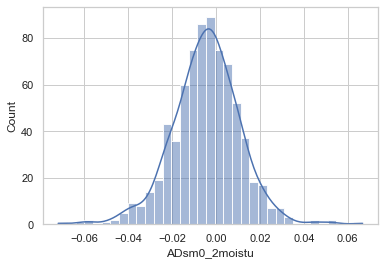

In [96]:
sns.set_theme(style='whitegrid')
sns.histplot(x=regiondata['ADsm0_2moistu'], kde=True)

In [ ]:
regiondata.plot()
#    column='ADsm0_2moistu', 
#    scheme='Quantiles', 
#    legend=True, 
#    edgecolor='none',
#    legend_kwds={'loc': 'lower left'}, 
#    figsize=(12, 12)
#)
#plt.show()

In [ ]:
# reprojecting to Lambert Azimuthal Equal Area Equatorial

regiondata.set_crs("+proj=laea +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs") #https://spatialreference.org/ref/sr-org/8668/
regiondata.crs

In [ ]:
regiondata.csr = "EPSG:4326"
regiondata.csr

---
# 6. Robustness
---

<h3><u>6.1 Robustness of Identification</u></h3>

As emphasised in Jonssón (2010), many "push factor" oriented papers tend to brush over the question of whether such a multi-dimensional process such as migration can really be analysed through such structural macro-level mechanisms. The multi-level contextual drivers literature, as Jonssón refers to it, emphasises people's agency and "analyse environmental factors [...] in relationship with wider social and structural changes" (2010, p.9). For a quantitative study such as Henderson et al. 2017, this **translates to a potential criticisms of the underlying DAG**. <span style="color:blue"> Explain (concisely) throug which avenues this "multi-dimensional drivers" approach threatens the identification strategy: i) unobservable variables (perhaps not even measurable: a) local perception of severity/change [this one can likely be correlated -> should expect discourse internalize drought], b) cultural factors ("la condition sahelienne"), ii) confounding variables [a) policies, b) practice of long-distance migration disrupted by drought, c) socially construced environmental changes like **land degradation and drought**], d) climatic events (such as drought), iii) ? ... </span>

It is in relation to these identification criticism that Henderson et al.'s robustness checks should be understood.

---
# 7. Conclusion
---

---
# 8. References
---

* **Ady 1965
* **Henderson, Storeygard, and Weil (2012)
* **Kolak and Anselin, 2019
* **Morgan and Winship, 2014)
* **Imbens and Rubin 2015
* **Imai and Kim (2020)
* **Castner, J., Dumas, M. and Grocev, P. (2014). Causal Inference with Spatially Disaggregated  Data: Some Potentials and Limits. Columbia Working Paper, Columbia University. [Online]. Available at: SSRN 2477484.
